In [359]:
%matplotlib inline
import pandas as pd
pd.set_option("display.max_rows",999)

import seaborn as sns
import matplotlib.pyplot as plt
from importlib import reload

import amr_pcr

## Get and Tidy Data

In [360]:
# read primer data
reload(amr_pcr)

primers = amr_pcr.read_primers('data/primers/tabula-333_primerliste-til-web-07-11-2013-9.tsv')
card = amr_pcr.CARD('CARD/card.json')

CARD version 2.0.2


In [361]:
amr_pcr.build_vaware_script(primers, 'primer_assessment', 3)

In [88]:
!mkdir -p vaware_canonical
with open('run_vaware_canonical.sh', 'w') as fh:
    iter_rows = primers.iterrows()
    for ix, row in iter_rows:
        name = row.loc['Primer name'].replace(" ", "_")
        name = re.escape(name)
        forward = row.loc['Sequence_tidy']
        ix, reverse = next(iter_rows)
        reverse = reverse.loc['Sequence_tidy']
        fh.write("VAware/build/vaware -t 3 -i CARD/nucleotide_fasta_protein_homolog_model.fasta -f {} -r {} > vaware_canonical/{}\n".format(forward, reverse, name))

In [82]:
!bash run_vaware_canonical.sh

In [10]:
!mkdir -p vaware_all_prot_nt
!cat CARD/nucleotide_fasta_protein_* CARD_prevalence/nucleotide_fasta_protein_*_variants.fasta > all_CARD_nt.fasta
with open('run_vaware_all.sh', 'w') as fh:
    iter_rows = primers.iterrows()
    for ix, row in iter_rows:
        name = row.loc['Primer name'].replace(" ", "_")
        name = re.escape(name)
        forward = row.loc['Sequence_tidy']
        ix, reverse = next(iter_rows)
        reverse = reverse.loc['Sequence_tidy']
        fh.write("VAware/build/vaware -t 2 -i  all_CARD_nt.fasta -f {} -r {} > vaware_all_prot_nt/{}\n".format(forward, reverse, name))
        fh.write('echo "{} done"\n'.format(name))

In [265]:
vim = amr_pcr.parse_vaware_output('vim')
vim = vim[vim['Name'].str.startswith("VIM")]

In [266]:
vim[vim['Name'].str.startswith('VIM')]['PCR_quality'].value_counts()

Perfect           76
Major Mismatch     8
Missed             6
Probable Fail      1
Name: PCR_quality, dtype: int64

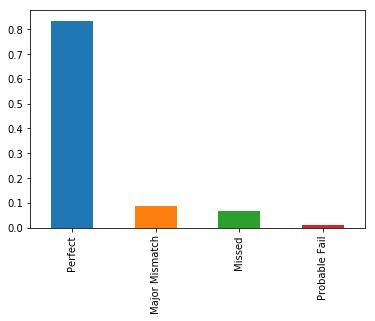

In [272]:
vim['PCR_quality'].value_counts().div(91).plot(kind='bar')

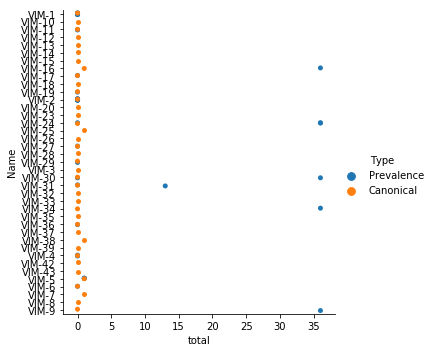

In [289]:
vim['total'] = vim['FP Mismatches'] + vim["RP Mismatches"]
vim.loc[vim['total'].isna(), 'total'] = 19+17
sns.catplot(data=vim, y='Name', hue='Type', x='total', order=vim['Name'].sort_values().drop_duplicates())


In [295]:
ndm = amr_pcr.parse_vaware_output('ndm')
ndm = ndm[ndm['Name'].str.startswith('NDM')]

In [335]:
a = ndm.groupby('Name')['PCR_quality'].value_counts().reset_index(level=0).rename(columns={'PCR_quality': 'Count'}).reset_index()
a['Percentage of Sequences'] = a.groupby('Name')['Count'].apply(lambda x: x/x.sum() * 100)
a['name_ix'] = a['Name'].str.split('-').str.get(-1).astype(int)
a = a.sort_values('name_ix')

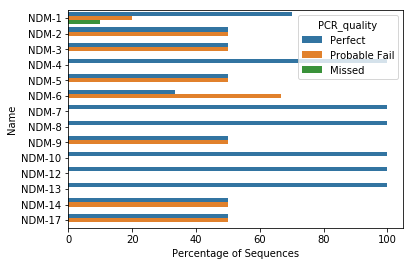

In [336]:
sns.barplot(data = a, y='Name', x='Percentage of Sequences', hue='PCR_quality')

In [338]:
ndm[ndm['Name'] == 'NDM-15']

,SILVA ID,Taxonomy,FP Matches,FP Mismatches,FP Gaps,FP 3' Mismatches,FP Align Begin,FP Align End,RP Matches,RP Mismatches,RP Gaps,RP 3' Mismatches,RP Align Begin,RP Align End,Insert Length,Name,Type,PCR_quality,Reason


In [342]:
!grep "NDM-15" data/CARD/card.json

In [343]:
ndm

,SILVA ID,Taxonomy,FP Matches,FP Mismatches,FP Gaps,FP 3' Mismatches,FP Align Begin,FP Align End,RP Matches,RP Mismatches,RP Gaps,RP 3' Mismatches,RP Align Begin,RP Align End,Insert Length,Name,Type,PCR_quality,Reason
1122,Prevalence_Sequence_ID:1511|ARO_Name:NDM-5|ARO...,Homolog Model,20.0,0.0,0.0,0.0,133.0,153.0,20.0,0.0,0.0,0.0,754.0,734.0,621.0,NDM-5,Prevalence,Perfect,Perfect Match
1143,Prevalence_Sequence_ID:1542|ARO_Name:NDM-1|ARO...,Homolog Model,20.0,0.0,0.0,0.0,133.0,153.0,20.0,0.0,0.0,0.0,754.0,734.0,621.0,NDM-1,Prevalence,Perfect,Perfect Match
4636,Prevalence_Sequence_ID:8058|ARO_Name:NDM-7|ARO...,Homolog Model,20.0,0.0,0.0,0.0,133.0,153.0,20.0,0.0,0.0,0.0,754.0,734.0,621.0,NDM-7,Prevalence,Perfect,Perfect Match
5656,Prevalence_Sequence_ID:9710|ARO_Name:NDM-3|ARO...,Homolog Model,12.0,8.0,0.0,1.0,51.0,71.0,20.0,0.0,0.0,0.0,379.0,359.0,328.0,NDM-3,Prevalence,Probable Fail,Non-gap or terminal mismatches (>5)
10428,Prevalence_Sequence_ID:14492|ARO_Name:NDM-1|AR...,Homolog Model,20.0,0.0,0.0,0.0,133.0,153.0,20.0,0.0,0.0,0.0,754.0,734.0,621.0,NDM-1,Prevalence,Perfect,Perfect Match
10470,Prevalence_Sequence_ID:14533|ARO_Name:NDM-1|AR...,Homolog Model,20.0,0.0,0.0,0.0,133.0,153.0,20.0,0.0,0.0,0.0,754.0,734.0,621.0,NDM-1,Prevalence,Perfect,Perfect Match
10496,Prevalence_Sequence_ID:14559|ARO_Name:NDM-1|AR...,Homolog Model,20.0,0.0,0.0,0.0,130.0,150.0,20.0,0.0,0.0,0.0,751.0,731.0,621.0,NDM-1,Prevalence,Perfect,Perfect Match
10512,Prevalence_Sequence_ID:14576|ARO_Name:NDM-1|AR...,Homolog Model,20.0,0.0,0.0,0.0,133.0,153.0,20.0,0.0,0.0,0.0,754.0,734.0,621.0,NDM-1,Prevalence,Perfect,Perfect Match
17402,Prevalence_Sequence_ID:21992|ARO_Name:NDM-4|AR...,Homolog Model,20.0,0.0,0.0,0.0,133.0,153.0,20.0,0.0,0.0,0.0,754.0,734.0,621.0,NDM-4,Prevalence,Perfect,Perfect Match
21974,Prevalence_Sequence_ID:27073|ARO_Name:NDM-6|AR...,Homolog Model,20.0,0.0,0.0,0.0,133.0,153.0,13.0,7.0,2.0,2.0,369.0,347.0,236.0,NDM-6,Prevalence,Probable Fail,Multiple gap or terminal mismatches


In [320]:
a.groupby('Name').apply(lambda x: x/x.sum())

ValueError: operands could not be broadcast together with shapes (6,) (2,) 

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13]),
 <a list of 14 Text xticklabel objects>)

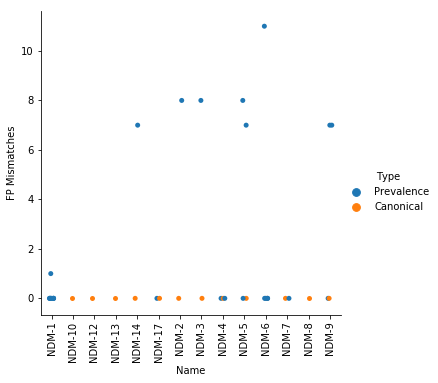

In [21]:
g = sns.catplot(x="Name", y="FP Mismatches", hue="Type", data=df)
plt.xticks(rotation=90)

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13]),
 <a list of 14 Text xticklabel objects>)

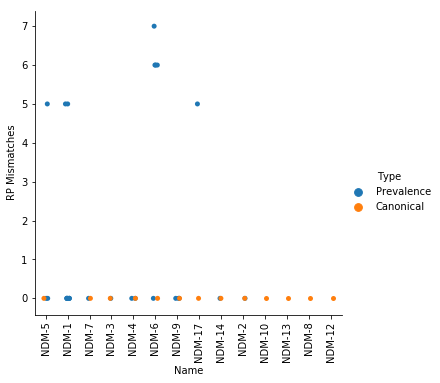

In [18]:
g = sns.catplot(x="Name", y="RP Mismatches", hue="Type", data=df)
plt.xticks(rotation=90)

In [71]:
df_nonndm = df_full[~df_full['SILVA ID'].str.contains('NDM')]